# **XGBoost Model**

## Import Libraries

In [56]:
import pandas as pd
import numpy as np
import math
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from xgboost import plot_importance
import xgboost as xgb

import shap

## Load Dataset

In [57]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')
# df = df.sample(frac=0.25, random_state=10)

## Explore the Data

In [58]:
df.shape

(364661, 11)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364661 entries, 0 to 364660
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  364661 non-null  object 
 1   vendor_id           364661 non-null  int64  
 2   pickup_datetime     364661 non-null  object 
 3   dropoff_datetime    364661 non-null  object 
 4   passenger_count     364661 non-null  int64  
 5   pickup_longitude    364661 non-null  float64
 6   pickup_latitude     364661 non-null  float64
 7   dropoff_longitude   364661 non-null  float64
 8   dropoff_latitude    364661 non-null  float64
 9   store_and_fwd_flag  364661 non-null  object 
 10  trip_duration       364661 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 30.6+ MB


In [60]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660
1,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833
2,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490
3,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767
4,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199


In [61]:
df['dropoff_datetime'].min()

'2016-01-01 00:12:42'

In [62]:
df['dropoff_datetime'].max()

'2016-07-01 13:26:40'

In [63]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [64]:
(df.isnull().sum()/(len(df)))*100

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [65]:
df.nunique()

id                    364661
vendor_id                  2
pickup_datetime       359649
dropoff_datetime      359550
passenger_count            9
pickup_longitude       16806
pickup_latitude        34806
dropoff_longitude      22718
dropoff_latitude       44747
store_and_fwd_flag         2
trip_duration           5407
dtype: int64

In [66]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,364661.0,1.535958,0.498706,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,364661.0,1.666049,1.316111,0.000000,1.000000,1.000000,2.000000,9.000000
pickup_longitude,364661.0,-73.973406,0.044367,-77.440750,-73.991875,-73.981705,-73.967285,-61.335529
pickup_latitude,364661.0,40.750939,0.031035,35.310307,40.737442,40.754108,40.768391,41.319164
dropoff_longitude,364661.0,-73.973412,0.043817,-79.817978,-73.991341,-73.979790,-73.963036,-61.335529
dropoff_latitude,364661.0,40.751834,0.035182,35.173546,40.735840,40.754559,40.769878,41.480755
trip_duration,364661.0,954.927448,3203.464143,1.000000,397.000000,662.000000,1076.000000,86390.000000


## Preliminary Feature Engineering

### Create new features from pickup_datetime and dropoff_datetime

In [67]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [68]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_month'] = df['pickup_datetime'].dt.month

In [69]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month
0,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660,Saturday,5,0,1
1,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833,Wednesday,2,19,2
2,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490,Thursday,3,6,5
3,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767,Thursday,3,8,1
4,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199,Saturday,5,13,1


### Calculate Haversine great-circle distance

In [70]:
def calculate_haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance between two points
    on a sphere given their longitudes and latitudes.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])    
    dlon = lon2 - lon1
    dlat = lat2 - lat1   
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6378.137 * c
    
    return haversine_distance

In [71]:
df['haversine_distance'] = calculate_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance
0,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660,Saturday,5,0,1,1.341484
1,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833,Wednesday,2,19,2,4.818762
2,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490,Thursday,3,6,5,2.016166
3,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767,Thursday,3,8,1,1.730221
4,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199,Saturday,5,13,1,0.650929


### Calculate Manhattan distance

In [72]:
def calculate_manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Calculates Manhattan distance between two points using their latitude and longitude.
    """
    a = calculate_haversine_distance(lat1, lon1, lat1, lon2)
    b = calculate_haversine_distance(lat1, lon1, lat2, lon1)
    manhattan_distance = a + b
    
    return manhattan_distance

In [73]:
df['manhattan_distance'] = df.apply(lambda row: calculate_manhattan_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance
0,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660,Saturday,5,0,1,1.341484,1.748711
1,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833,Wednesday,2,19,2,4.818762,6.813560
2,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490,Thursday,3,6,5,2.016166,2.383142
3,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767,Thursday,3,8,1,1.730221,2.104292
4,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199,Saturday,5,13,1,0.650929,0.920104


### Convert latitude and longitude to Polar coordinates

In [74]:
def convert_to_polar_coordinates(lat, lon):
    """
    Converts latitude and longitude to polar coordinates.
    """
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    # Convert to polar coordinates
    r = math.sqrt(lat_rad**2 + lon_rad**2)
    phi = math.atan2(lon_rad, lat_rad)

    return r, phi

In [75]:
df['pickup_r'], df['pickup_phi'] = zip(*df.apply(lambda row: convert_to_polar_coordinates(row['pickup_latitude'], row['pickup_longitude']), axis=1))
df['dropoff_r'], df['dropoff_phi'] = zip(*df.apply(lambda row: convert_to_polar_coordinates(row['dropoff_latitude'], row['dropoff_longitude']), axis=1))

In [76]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi
0,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,...,Saturday,5,0,1,1.341484,1.748711,1.474370,-1.067662,1.474106,-1.067625
1,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,...,Wednesday,2,19,2,4.818762,6.813560,1.474095,-1.066935,1.474465,-1.067482
2,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,...,Thursday,3,6,5,2.016166,2.383142,1.473979,-1.067677,1.474306,-1.067848
3,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,...,Thursday,3,8,1,1.730221,2.104292,1.474064,-1.067117,1.474268,-1.066989
4,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,...,Saturday,5,13,1,0.650929,0.920104,1.473876,-1.066884,1.473824,-1.066810


### Calculate bearing

In [77]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates bearing between two points using their latitude and longitude.
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing angle
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    initial_bearing = np.arctan2(x, y)

    # Normalize the initial bearing to 0° ... 360°
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [78]:
df['bearing'] = df.apply(lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing
0,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,...,5,0,1,1.341484,1.748711,1.474370,-1.067662,1.474106,-1.067625,112.183219
1,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,...,2,19,2,4.818762,6.813560,1.474095,-1.066935,1.474465,-1.067482,225.645152
2,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,...,3,6,5,2.016166,2.383142,1.473979,-1.067677,1.474306,-1.067848,258.305158
3,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,...,3,8,1,1.730221,2.104292,1.474064,-1.067117,1.474268,-1.066989,345.689279
4,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,...,5,13,1,0.650929,0.920104,1.473876,-1.066884,1.473824,-1.066810,46.814269


## Outlier Handling

### Passenger count

In [79]:
df = df[df['passenger_count'] > 0]
df = df[df['passenger_count'] < 7]

### Lonitude and latitude

In [80]:
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]
df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

### Trip duration - Taget

In [81]:
df['trip_duration'].mean() / 60

15.687235400090078

In [82]:
df['trip_duration_zscore'] = (df['trip_duration'] - df['trip_duration'].mean())/df['trip_duration'].std(ddof=0)
df.sort_values(by=['trip_duration_zscore'], ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing,trip_duration_zscore
24163,id0953667,2,2016-05-06 00:00:10,2016-05-07 00:00:00,1,-73.996010,40.753220,-73.979027,40.740601,N,...,0,5,2.006169,2.836882,1.474388,-1.067378,1.474023,-1.067412,134.438432,26.766388
54471,id2589925,2,2016-05-17 22:22:56,2016-05-18 22:22:35,4,-74.006111,40.734680,-73.958809,40.815449,N,...,22,5,9.835698,12.981118,1.474387,-1.067628,1.474344,-1.066521,23.901930,26.762942
6244,id3346235,2,2016-05-09 15:59:04,2016-05-10 15:58:42,5,-73.982658,40.761963,-73.988976,40.743023,N,...,15,5,2.174646,2.641028,1.474258,-1.067211,1.474195,-1.067444,194.181914,26.762629
244314,id2307896,2,2016-05-14 04:48:05,2016-05-15 04:47:42,1,-74.000504,40.732121,-73.994202,40.712418,N,...,4,5,2.256838,2.724909,1.474280,-1.067623,1.474017,-1.067791,166.372019,26.762316
54309,id3741436,2,2016-02-21 00:46:56,2016-02-22 00:46:21,3,-73.986298,40.734531,-73.992271,40.749088,N,...,0,2,1.696987,2.124365,1.474083,-1.067517,1.474297,-1.067400,342.730132,26.758557


In [83]:
df = df[df['trip_duration_zscore'] < 2]
df.drop(['trip_duration_zscore'], axis=1, inplace=True)

## Feature Correlations (Numerical Features)

In [84]:
numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numeric)
df_numeric.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing
0,2,1,-74.006615,40.731712,-73.991890,40.727161,660,5,0,1,1.341484,1.748711,1.474370,-1.067662,1.474106,-1.067625,112.183219
1,1,3,-73.963203,40.777924,-74.004059,40.747654,1833,2,19,2,4.818762,6.813560,1.474095,-1.066935,1.474465,-1.067482,225.645152
2,2,1,-73.987595,40.719822,-74.010994,40.716148,490,3,6,5,2.016166,2.383142,1.473979,-1.067677,1.474306,-1.067848,258.305158
3,2,1,-73.969055,40.763618,-73.974129,40.778679,767,3,8,1,1.730221,2.104292,1.474064,-1.067117,1.474268,-1.066989,345.689279
4,2,2,-73.950165,40.775635,-73.944534,40.779636,199,5,13,1,0.650929,0.920104,1.473876,-1.066884,1.473824,-1.066810,46.814269


<Axes: >

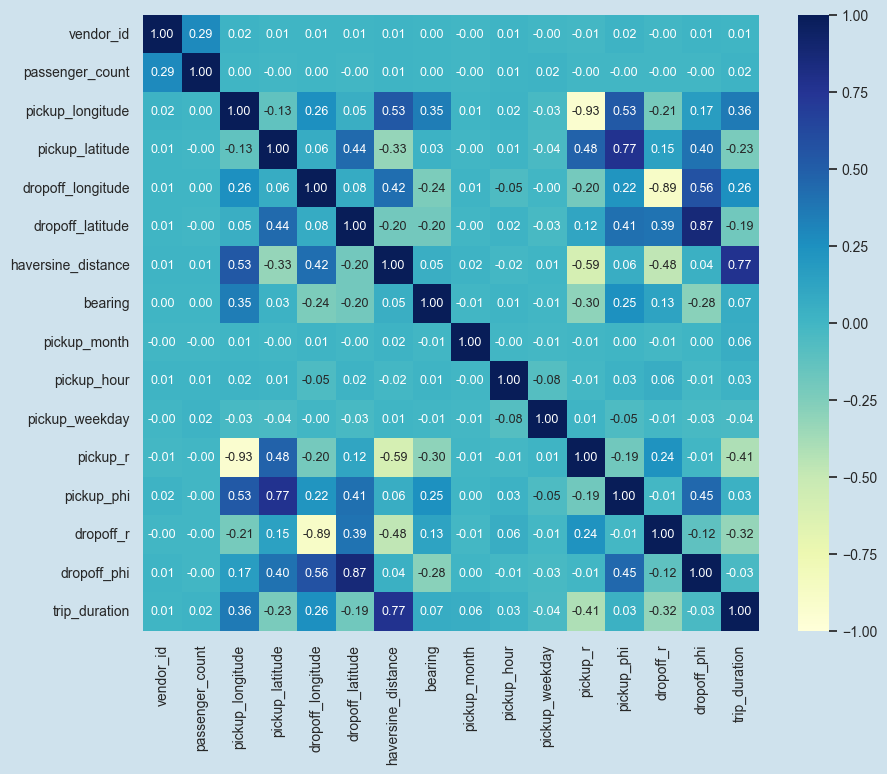

In [85]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(10, 8), 'grid.linestyle': '--'})

num_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'haversine_distance', 'bearing', 'pickup_month', 'pickup_hour', 'pickup_weekday', 'pickup_r', 'pickup_phi', 'dropoff_r', 'dropoff_phi']
num_features_target = copy.copy(num_features)
num_features_target.append('trip_duration')
sns.heatmap(data=df[num_features_target].corr(), square=True, annot=True, annot_kws={'size': 9}, fmt=".2f", vmin=-1, vmax=1, cmap="YlGnBu")

## Train and Select XGBoost Regression Model v0

In [86]:
num_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'haversine_distance', 'bearing', 'pickup_month', 'pickup_hour', 'pickup_weekday', 'pickup_r', 'pickup_phi', 'dropoff_r', 'dropoff_phi']
# cat_features = ['pickup_day']
features = num_features
target = 'trip_duration'

In [87]:
y = df[target]
X = df[features]

In [88]:
# In case if there are any categorical features - for the next iteration of feature engineering

# Extract categorical features
# cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
# X = X.copy()
# for col in cats:
#    X[col] = X[col].astype('category')

In [89]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359143 entries, 0 to 364660
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vendor_id           359143 non-null  int64  
 1   passenger_count     359143 non-null  int64  
 2   pickup_longitude    359143 non-null  float64
 3   pickup_latitude     359143 non-null  float64
 4   dropoff_longitude   359143 non-null  float64
 5   dropoff_latitude    359143 non-null  float64
 6   haversine_distance  359143 non-null  float64
 7   bearing             359143 non-null  float64
 8   pickup_month        359143 non-null  int32  
 9   pickup_hour         359143 non-null  int32  
 10  pickup_weekday      359143 non-null  int32  
 11  pickup_r            359143 non-null  float64
 12  pickup_phi          359143 non-null  float64
 13  dropoff_r           359143 non-null  float64
 14  dropoff_phi         359143 non-null  float64
dtypes: float64(10), int32(3), int64(2)
memo

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

In [91]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

In [92]:
# Create regression matrices with categorical features - XGBoost supports Pandas categorical columns
# dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
# dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

## Training

In [93]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "eta": 0.1, "random_state": 10}

In [94]:
evals = [(dtrain_reg, "train"), (dtest_reg, "test")]

In [95]:
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=10000,
    evals=evals,
    verbose_eval=100,
    early_stopping_rounds=50
)

[0]	train-rmse:594.30754	test-rmse:596.59178
[100]	train-rmse:284.45341	test-rmse:292.47304
[200]	train-rmse:271.11736	test-rmse:285.02449
[300]	train-rmse:263.16299	test-rmse:282.39267
[400]	train-rmse:257.44836	test-rmse:280.82876
[500]	train-rmse:252.91177	test-rmse:280.14384
[600]	train-rmse:248.48162	test-rmse:279.55179
[700]	train-rmse:244.36590	test-rmse:278.99739
[800]	train-rmse:240.73068	test-rmse:278.85511
[900]	train-rmse:237.56517	test-rmse:278.83233
[924]	train-rmse:236.81618	test-rmse:278.90297


## Evaluation

In [96]:
predictions = model.predict(dtest_reg)

In [97]:
rmse = root_mean_squared_error(y_test, predictions)
print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 278.904


## Cross-Validation

In [98]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "eta": 0.1, "random_state": 10}

In [99]:
results = xgb.cv(
    params, dtrain_reg,
    num_boost_round=1000,
    nfold=5,
    verbose_eval=100,
    early_stopping_rounds=50
)

[0]	train-rmse:594.28828+0.92364	test-rmse:594.36109+3.97810
[100]	train-rmse:282.95393+0.67459	test-rmse:291.49302+2.24694
[200]	train-rmse:269.09888+0.70149	test-rmse:284.59276+2.19929
[300]	train-rmse:260.43169+0.64345	test-rmse:281.88407+2.38164
[400]	train-rmse:253.95419+0.64293	test-rmse:280.67855+2.48498
[500]	train-rmse:248.58732+0.69682	test-rmse:280.03575+2.56446
[600]	train-rmse:243.87187+0.78990	test-rmse:279.52487+2.46013
[700]	train-rmse:239.54464+0.80601	test-rmse:279.23934+2.47213
[800]	train-rmse:235.60493+0.74641	test-rmse:279.07888+2.45420
[900]	train-rmse:231.90224+0.72444	test-rmse:279.01819+2.45811
[976]	train-rmse:229.30274+0.62968	test-rmse:278.98469+2.47990


In [100]:
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,594.288282,0.923636,594.361092,3.978100
1,556.669453,0.876262,556.804769,3.769146
2,523.973074,0.799904,524.235985,3.643821
3,495.533434,0.735906,495.840574,3.533025
4,471.023261,0.703017,471.424385,3.452221


In [101]:
best_rmse = results['test-rmse-mean'].min()
best_rmse

278.97207821339447

## Classic Feature Importances (XGBoost)

#### Global feature importance calcuations are included with XGBoost library. But they calculate feature importances based on different importace types: Weight, Gain and Cover.
#### This could lead to inconsistency in calculating feature importances since one of the types needs to be selected based on reasoning that could change over time.
#### To resolve this, a SHAP (SHapley Additive exPlanations) concept is used. SHAP is a game theoretic approach to explain the output of any machine learning model.

Text(0.5, 1.0, 'Feature Importance (Importance Type: Weight)')

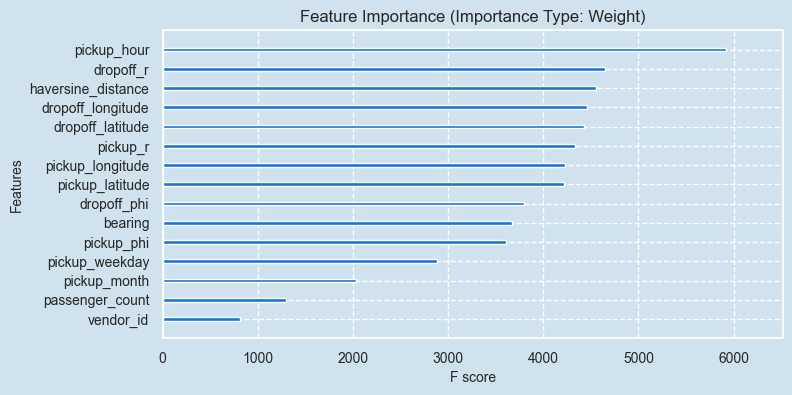

In [102]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model, importance_type='weight', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Weight)')

Text(0.5, 1.0, 'Feature Importance (Importance Type: Gain)')

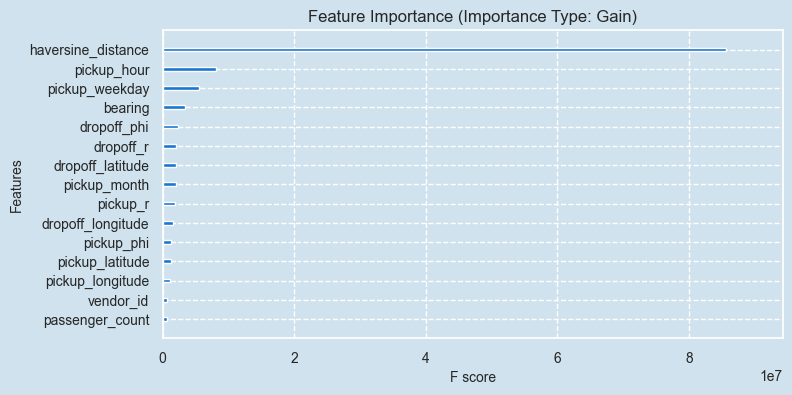

In [103]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model, importance_type='gain', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Gain)')

Text(0.5, 1.0, 'Feature Importance (Importance Type: Cover)')

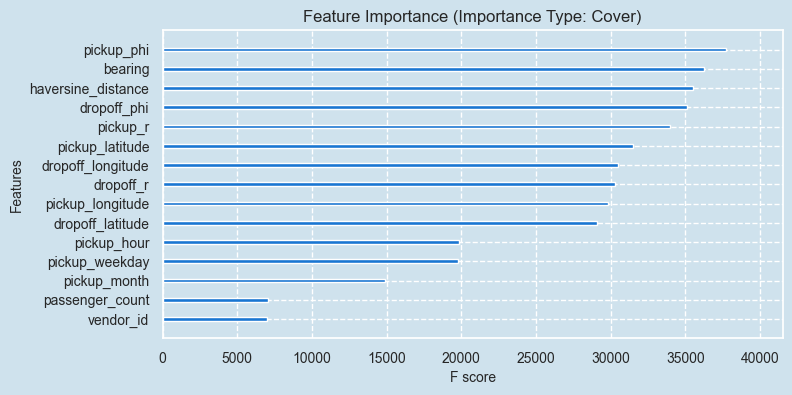

In [104]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model, importance_type='cover', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Cover)')

## Feature Importances (SHAP)

In [105]:
# Select a sample to speed up calculations
X_sampled = X_train.sample(10000, random_state=10)

In [106]:
# Explain model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_sampled)

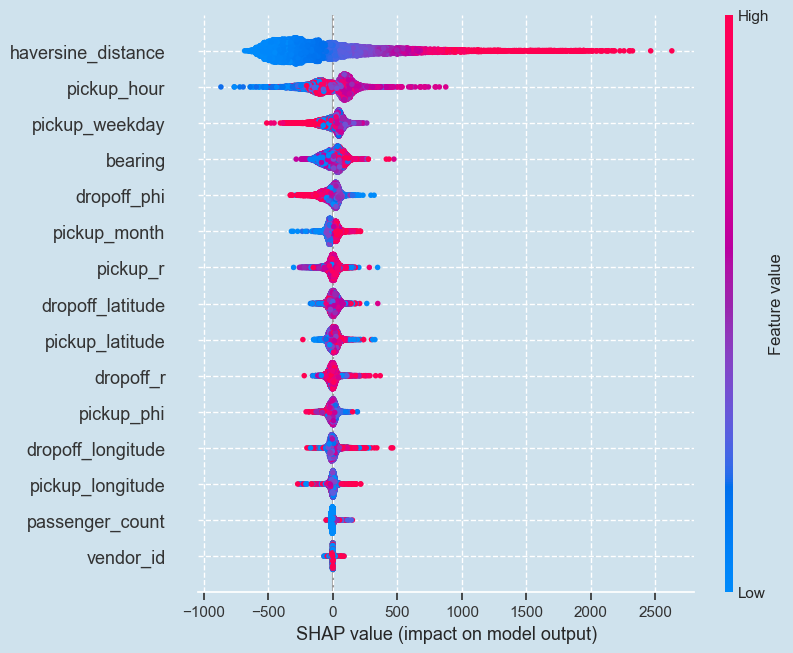

In [107]:
# Summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(features))

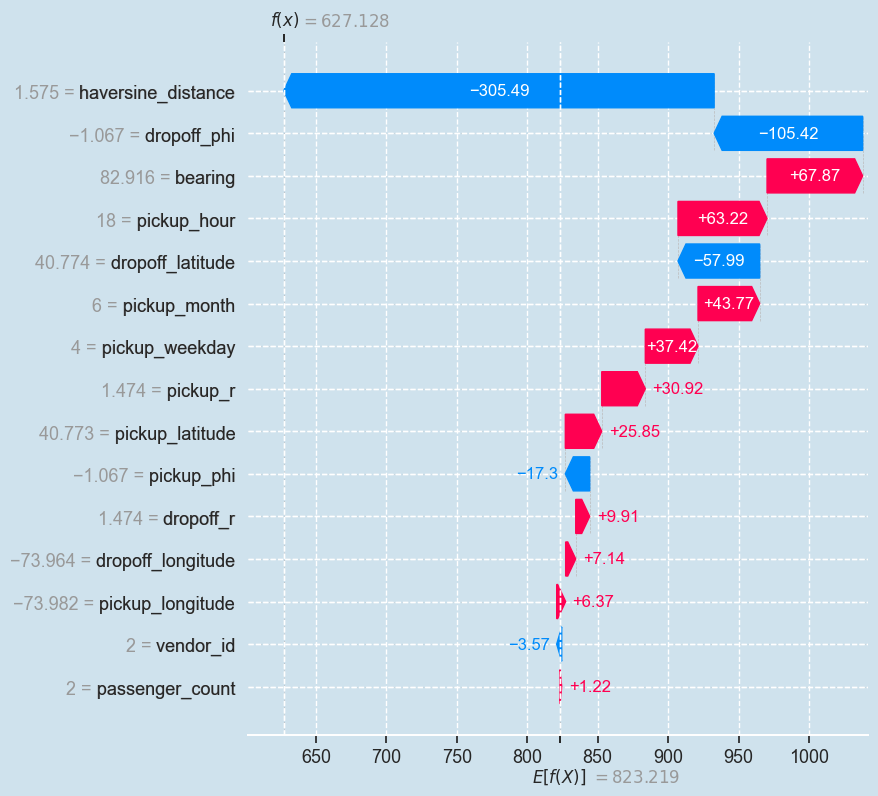

In [108]:
# Visualize model v0 prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=len(features))

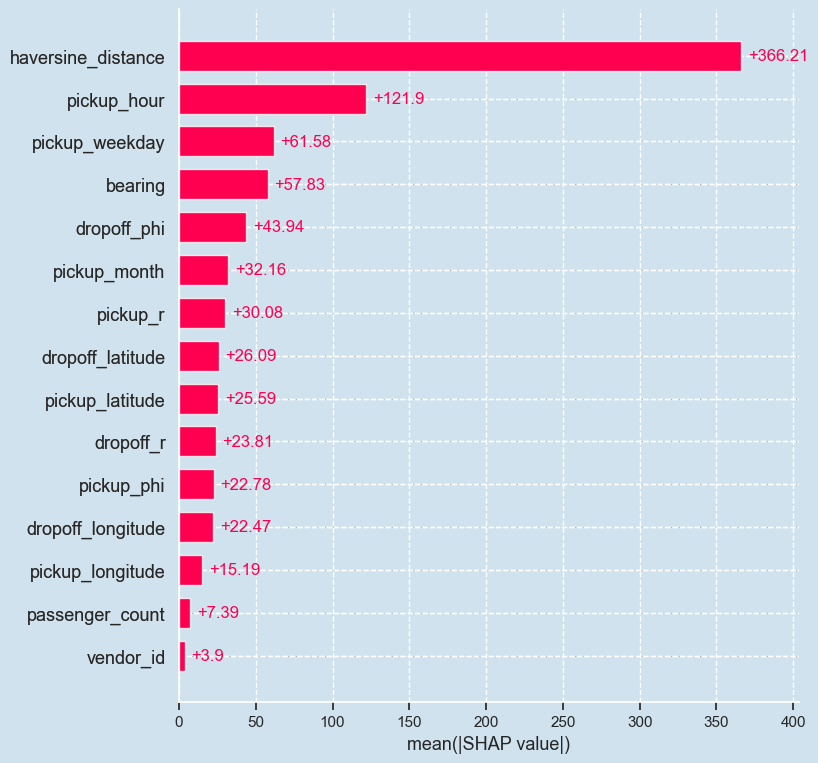

In [109]:
# Feature importance bar chart
shap.plots.bar(shap_values, max_display=len(features))

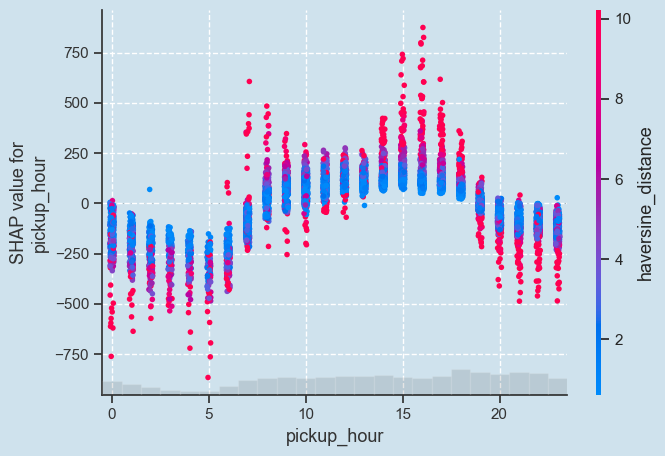

In [110]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "pickup_hour"], color=shap_values)